# Combined time series figure with vertical profile

In [1]:
## import required packages
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
import string
import s3fs
import gsw
import warnings
warnings.filterwarnings("ignore", module='distributed')

In [2]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:39367")
client

<Client: 'tcp://127.0.0.1:39367' processes=8 threads=32, memory=123.95 GiB>

In [3]:
# initialize s3 filesystem
s3_options = dict(anon=False)

In [4]:
# open geometry file for HH field
HH_grid = xr.open_dataset("~/efs-mount-point/mzahn/sassie/HH/GRID/GRID_GEOMETRY_SASSIE_HH_V1R1_NATIVE_LLC1080.nc")

In [5]:
# function to open zarr store with a provided s3 bucket path
def open_zarr_store(s3_path, s3_options):
    # initalize s3 file system
    s3 = s3fs.S3FileSystem(**s3_options)

    # define location of zarr store and open
    store = s3fs.S3Map(root=s3_path, s3=s3, check=False)
    zarr_store = xr.open_zarr(store)
    
    return zarr_store

### Open ZARR datasets

In [6]:
# open SALT zarr store - [psu]
SALT_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/SALT_AVG_DAILY.ZARR/', s3_options)

# open THETA zarr store - [degC]
THETA_zarr_day = open_zarr_store('s3://ecco-processed-data/SASSIE/N1/HH/ZARR/THETA_AVG_DAILY.ZARR/', s3_options)

In [7]:
# open FWC dataset
fwc_yrs_masked = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/FWC/FWC_masked_Beaufort_final.ZARR')
fwc_yrs_masked = fwc_yrs_masked.fwc

In [8]:
# open SIC dataset
sic_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/SIC/SIC_masked_Beaufort.ZARR')

ice_fwc_over_2m = sic_ds.sic.where(fwc_yrs_masked>2).load()
ice_fwc_under_2m = sic_ds.sic.where(fwc_yrs_masked<2).load()

In [9]:
# open OHC zarr stores
ohc_mld_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_MLD_Beaufort_final.ZARR')
ohc_pyc_ds = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/OHC/OHC_PYC_Beaufort_final.ZARR')

# select all cells with FWC above and below 2
ohc_fwc_over_2m =(ohc_mld_ds.ohc/1e6).where(fwc_yrs_masked>2).load() # convert J to MJ
ohc_fwc_under_2m = (ohc_mld_ds.ohc/1e6).where(fwc_yrs_masked<2).load() # convert J to MJ

ohc_pyc_fwc_over_2m = (ohc_pyc_ds.ohc_pyc/1e6).where(fwc_yrs_masked>2).load()
ohc_pyc_fwc_under_2m = (ohc_pyc_ds.ohc_pyc/1e6).where(fwc_yrs_masked<2).load()

In [10]:
# open MLD dataset
mld_da = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/MLD/MLD_Beaufort_final.ZARR')

# select all cells with FWC above and below 2
mld_fwc_over_2m = (mld_da.mld.where(fwc_yrs_masked>2)*-1).load()
mld_fwc_under_2m = (mld_da.mld.where(fwc_yrs_masked<2)*-1).load()

In [11]:
strat_da = xr.open_zarr('/home/jpluser/efs-mount-point/mzahn/sassie/HH/ZARR/STRAT/STRAT_Beaufort.ZARR')

# select all cells with FWC>2
strat_fwc_over_2m = strat_da.sigma.where(fwc_yrs_masked>2).load()
strat_fwc_under_2m = strat_da.sigma.where(fwc_yrs_masked<2).load()

### Add vertical lines for where SIC>=15% and remain above it for at least 5 days


In [12]:
# first day when sea ice concentration (SIC) reaches or exceeds 15% and stays above that threshold for at least 5 consecutive days
years = np.arange(2014, 2021)

ice_fwc_over_2m_dates = []
ice_fwc_under_2m_dates = []

for year in years:
    # Compute mean SIC over space
    ice_over_mean = ice_fwc_over_2m.sel(time=str(year)).mean(dim=['i', 'j'], skipna=True).compute()
    ice_under_mean = ice_fwc_under_2m.sel(time=str(year)).mean(dim=['i', 'j'], skipna=True).compute()
    
    # Convert to boolean where SIC >= 15
    ice_over_bool = ice_over_mean >= 15
    ice_under_bool = ice_under_mean >= 15

    # Find the first day where there are 5+ consecutive True values
    def find_persistent_threshold(bool_array, time_array, window=5):
        bool_np = bool_array.values
        for i in range(len(bool_np) - window + 1):
            if np.all(bool_np[i:i+window]):
                return time_array[i].values
        return np.datetime64('NaT')  # If no valid period found

    over_time = ice_over_mean['time']
    under_time = ice_under_mean['time']

    ice_over_date = find_persistent_threshold(ice_over_bool, over_time)
    ice_under_date = find_persistent_threshold(ice_under_bool, under_time)

    ice_fwc_over_2m_dates.append(ice_over_date)
    ice_fwc_under_2m_dates.append(ice_under_date)

## Plot mean of all time series

In [14]:
def compute_aligned_stats(data_over, data_under, year):
    # Select data for a specific year
    data_over_yr = data_over.sel(time=str(year))
    data_under_yr = data_under.sel(time=str(year))

    # Find the first valid sea ice day (non-NaN mean)
    mean_over = data_over_yr.mean(dim=['i', 'j'])
    first_valid_index = mean_over.notnull().argmax().compute().item()

    # Slice data from that index onward
    mean_over = mean_over.isel(time=slice(first_valid_index, None))
    mean_under = data_under_yr.mean(dim=['i', 'j']).isel(time=slice(first_valid_index, None))

    std_over = data_over_yr.isel(time=slice(first_valid_index, None)).std(dim=['i', 'j'])
    std_under = data_under_yr.isel(time=slice(first_valid_index, None)).std(dim=['i', 'j'])

    x = np.arange(len(mean_over))  # relative day index

    return x, mean_over, std_over, mean_under, std_under

def plot_variable_row(fig, axes_row, year, variable_pairs, titles, ice_fwc_over_2m_dates, ice_fwc_under_2m_dates, row_idx):
    for j, ((data_over, data_under), title) in enumerate(zip(variable_pairs, titles)):
        ax = axes_row[j]
        x, mean_over, std_over, mean_under, std_under = compute_aligned_stats(data_over, data_under, year)

        ax.plot(x, mean_over, color='tab:blue', label='FWC > 2m')
        ax.fill_between(x, mean_over - std_over, mean_over + std_over, color='tab:blue', alpha=0.3)

        ax.plot(x, mean_under, color='k', label='FWC < 2m')
        ax.fill_between(x, mean_under - std_under, mean_under + std_under, color='gray', alpha=0.2)

        ax.set_xlim([0, 60])
        ax.grid(True)

        if j == 0:
            ax.set_ylabel(f"{year}", rotation=0, labelpad=30, fontsize=16)
            ax.axvline(x=np.where(mean_over.time.values == ice_fwc_over_2m_dates[row_idx])[0][0],color='tab:blue',linestyle='dashed')
            ax.axvline(x=np.where(mean_under.time.values == ice_fwc_under_2m_dates[row_idx])[0][0],color='k',linestyle='dashed')
            
        if year == 2014:
            ax.set_title(title, fontsize=16)

In [15]:
def normalize_and_avg_da(da, group_dim='time.year', min_day_dim='days_since_min',
                         time_dim='time'):
    """
    Normalize a DataArray by computing days since the start of each year (or group),
    then compute the mean and std over space and group (e.g., year).

    Parameters:
    -----------
    da : xarray.DataArray
        The input DataArray with dimensions including time and spatial dims.
    group_dim : str
        The time-based group dimension for separation (default: 'time.year').
    min_day_dim : str
        The name for the new time coordinate (default: 'days_since_min').
    time_dim : str
        The name of the time dimension (default: 'time').

    Returns:
    --------
    da_mean : xarray.DataArray
        Mean over space and group. Dims: (days_since_min,)
    da_std : xarray.DataArray
        Std deviation over space and group. Dims: (days_since_min,)
    """
    normalized_list = []

    for group_val, da_group in da.groupby(group_dim):
        days_since = ((da_group[time_dim] - da_group[time_dim].values[0]) /
                      np.timedelta64(1, 'D')).astype(int)
        da_group = da_group.assign_coords({time_dim: days_since.data})
        da_group = da_group.rename({time_dim: min_day_dim})
        da_group = da_group.expand_dims(dim={group_dim.split('.')[-1]: [group_val]})
        normalized_list.append(da_group)

    da_normalized = xr.concat(normalized_list, dim=group_dim.split('.')[-1])
    da_mean = da_normalized.mean(dim=[group_dim.split('.')[-1]])
    da_std = da_normalized.std(dim=[group_dim.split('.')[-1]])

    return da_mean, da_std

In [16]:
# first take mean for each group
ice_fwc_over_2m_avg = ice_fwc_over_2m.mean(dim=['i','j'])
ice_fwc_under_2m_avg = ice_fwc_under_2m.mean(dim=['i','j'])

ohc_fwc_over_2m_avg = ohc_fwc_over_2m.mean(dim=['i','j'])
ohc_fwc_under_2m_avg = ohc_fwc_under_2m.mean(dim=['i','j'])

ohc_pyc_fwc_over_2m_avg = ohc_pyc_fwc_over_2m.mean(dim=['i','j'])
ohc_pyc_fwc_under_2m_avg = ohc_pyc_fwc_under_2m.mean(dim=['i','j'])

mld_fwc_over_2m_avg = mld_fwc_over_2m.mean(dim=['i','j'])
mld_fwc_under_2m_avg = mld_fwc_under_2m.mean(dim=['i','j'])

strat_fwc_over_2m_avg = strat_fwc_over_2m.mean(dim=['i','j'])
strat_fwc_under_2m_avg = strat_fwc_under_2m.mean(dim=['i','j'])

In [17]:
# compute normalized datasets and mean/std

# SIC --------------------------
sic_mean_over, sic_std_over = normalize_and_avg_da(ice_fwc_over_2m_avg)
sic_mean_under, sic_std_under = normalize_and_avg_da(ice_fwc_under_2m_avg)

# OHC in surface ML ------------
ohc_mean_over, ohc_std_over = normalize_and_avg_da(ohc_fwc_over_2m_avg)
ohc_mean_under, ohc_std_under = normalize_and_avg_da(ohc_fwc_under_2m_avg)

# OHC in pyc layer -------------
ohc_pyc_mean_over, ohc_pyc_std_over = normalize_and_avg_da(ohc_pyc_fwc_over_2m_avg)
ohc_pyc_mean_under, ohc_pyc_std_under = normalize_and_avg_da(ohc_pyc_fwc_under_2m_avg)

# MLD --------------------------
mld_mean_over, mld_std_over = normalize_and_avg_da(mld_fwc_over_2m_avg)
mld_mean_under, mld_std_under = normalize_and_avg_da(mld_fwc_under_2m_avg)

# stratification ---------------
strat_mean_over, strat_std_over = normalize_and_avg_da(strat_fwc_over_2m_avg)
strat_mean_under, strat_std_under = normalize_and_avg_da(strat_fwc_under_2m_avg)

In [18]:
def plot_var_mean(ax, var_mean_under, var_std_under, var_mean_over, var_std_over, upper_xy_limits=[80 ,100], title='SIC', ylabel=''):
    # Plot the variable mean + std shading for over and under FWC=2
    var_mean_over.plot(ax=ax, color='tab:blue')
    ax.fill_between(
        var_mean_over.days_since_min,
        var_mean_over - var_std_over,
        var_mean_over + var_std_over,
        color='tab:blue', alpha=0.2)

    var_mean_under.plot(ax=ax, color='k')
    ax.fill_between(
        var_mean_under.days_since_min,
        var_mean_under - var_std_under,
        var_mean_under + var_std_under,
        color='gray', alpha=0.2)

    ax.set_xlim(0, upper_xy_limits[0])
    ax.set_ylim(0, upper_xy_limits[1])
    ax.set_xlabel("")
    ax.set_title(title,size=15)
    ax.set_ylabel(ylabel)

In [19]:
def plot_sic_diff_shading(ax, sic_mean_over, sic_mean_under):
    diff = sic_mean_over.diff(dim='days_since_min',label="lower") - sic_mean_under.diff(dim='days_since_min',label="lower")
    x = diff['days_since_min']
    y = diff.values

    ax.plot(x, y, color='black',linewidth=0.8)
    ax.fill_between(x, y, 0, where=(y > 0), interpolate=True, color='tab:blue', alpha=0.4, label='Fresher Freezes Faster')
    ax.fill_between(x, y, 0, where=(y < 0), interpolate=True, color='gray', alpha=0.3, label='Saltier Freezes Faster')

    ax.set_xlim(0, 80)
    ax.set_ylim(-3, 4)
    ax.axhline(0, color='black', linewidth=0.8, linestyle='--')
    ax.legend(loc='upper right',fontsize=10)
    ax.set_title("  SIC Rate Difference",size=15)
    ax.set_xlabel("")
    ax.set_ylabel("Δ SIC Rate (%/day)")

In [20]:
def plot_sic_mean(ax, sic_mean_under, sic_std_under, sic_mean_over, sic_std_over, upper_xy_limits=[80, 100], title='SIC'):
    # Plot the SIC mean + std shading for over and under
    sic_mean_over.plot(ax=ax, color='tab:blue', label='Plume')
    ax.fill_between(
        sic_mean_over.days_since_min,
        sic_mean_over - sic_std_over,
        sic_mean_over + sic_std_over,
        color='tab:blue', alpha=0.2)

    sic_mean_under.plot(ax=ax, color='k', label='Adjacent')
    ax.fill_between(
        sic_mean_under.days_since_min,
        sic_mean_under - sic_std_under,
        sic_mean_under + sic_std_under,
        color='gray', alpha=0.2)

    # Function to find threshold crossings (>= 5 consecutive days > 15%)
    def find_threshold_crossings(sic_mean, threshold=15, min_duration=5):
        above = sic_mean > threshold
        above = above.astype(int).values
        crossings = []

        count = 0
        for i in range(len(above)):
            if above[i]:
                count += 1
                if count == min_duration:
                    crossings.append(sic_mean.days_since_min[i - min_duration + 1].item())
            else:
                count = 0
        return crossings

    # Add vertical lines for each group
    over_thresh = find_threshold_crossings(sic_mean_over)
    ax.axvline(over_thresh, color='tab:blue', linestyle='--', linewidth=1.6)

    under_thresh = find_threshold_crossings(sic_mean_under)
    ax.axvline(under_thresh, color='k', linestyle='--', linewidth=1.6)

    ax.set_xlim(0, upper_xy_limits[0])
    ax.set_ylim(0, upper_xy_limits[1])
    ax.set_yticks([0,25,50,75,100])
    ax.legend(fontsize=10,loc='lower right')
    ax.set_title(title,size=15)
    ax.set_xlabel("")
    ax.set_ylabel("SIC (%)")

    return under_thresh, over_thresh

In [21]:
def compute_potential_density(SALT_day, THETA_day, ref_lat=70):
    """
    Compute potential density anomaly referenced to 0 dbar.

    Args:
    - SALT_day: DataArray containing salinity (SALT), longitude (XC), and latitude (YC).
    - THETA_day: DataArray containing potential temperature (THETA).
    - ref_lat: Reference latitude for pressure calculation (default is 70°N).

    Returns:
    - sigma0: Potential density anomaly (kg/m3 - 1000).
    """
    # Convert depth (m) to pressure (dbar)
    p = gsw.p_from_z(SALT_day.Z, ref_lat)  # Depth is negative

    # Convert Practical Salinity (SP) to Absolute Salinity (SA)
    SA = gsw.SA_from_SP(SALT_day, p, SALT_day.XC, SALT_day.YC)

    # Convert Potential Temperature to Conservative Temperature
    CT = gsw.conversions.CT_from_pt(SA, THETA_day)

    # Calculate potential density anomaly referenced to 0 dbar
    sigma0 = gsw.sigma0(SA, CT)

    # Add metadata
    sigma0.name = 'potential_density'
    sigma0.attrs['long_name'] = 'potential_density'

    return sigma0 + 1000

In [22]:
# calculate potential density from in situ density
sigma = compute_potential_density(SALT_zarr_day.SALT, THETA_zarr_day.THETA, ref_lat=70)

In [23]:
# make depth positive downward
sigma = sigma.assign_coords(Z = sigma.Z * -1)

# subtract 1000
sigma = sigma - 1000

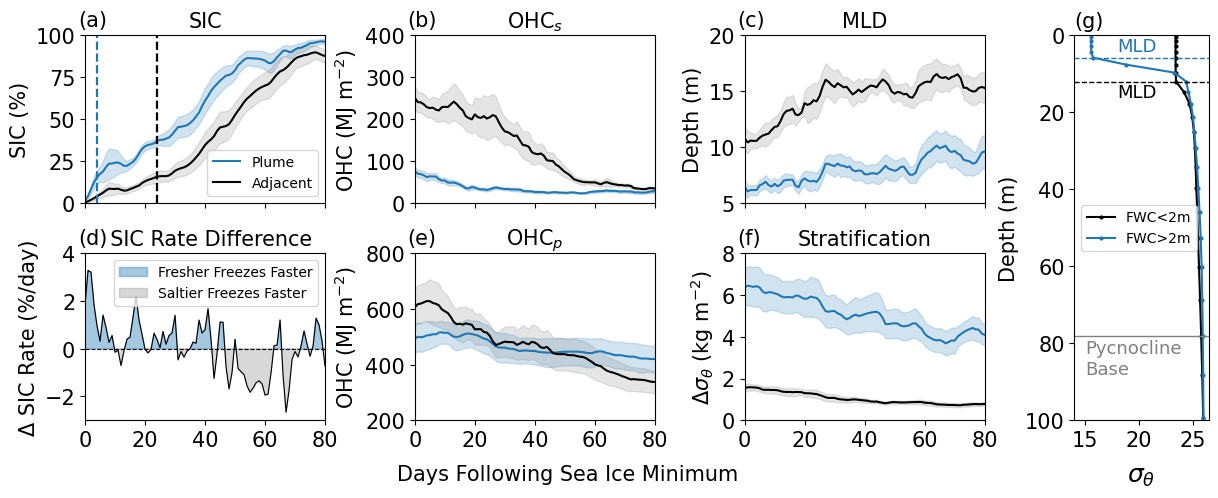

In [24]:
plt.rcParams['font.size'] = 15

# Set up figure with custom GridSpec
fig = plt.figure(figsize=(14.5, 5))  # Adjust width for added profile
gs = gridspec.GridSpec(2, 4, figure=fig, width_ratios=[1, 1, 1, 0.56], wspace=0.42, hspace=0.3)

# Create 2x3 grid axes
axs = [fig.add_subplot(gs[i, j]) for i in range(2) for j in range(3)]

# Create the extra axis for vertical profile (spanning both rows)
ax_profile = fig.add_subplot(gs[:, 3])

# Add subplot labels (a)-(g)
for i, ax in enumerate(axs):
    label = f"({string.ascii_lowercase[i]})"
    ax.text(-0.03, 1.15, label, transform=ax.transAxes,
            fontsize=15, va='top', ha='left')

# Plot data into axs[0] through axs[5]
plot_sic_mean(axs[0], sic_mean_under, sic_std_under/np.sqrt(7), sic_mean_over, sic_std_over/np.sqrt(7))
plot_var_mean(axs[1], ohc_mean_under, ohc_std_under/np.sqrt(7), ohc_mean_over, ohc_std_over/np.sqrt(7),
              upper_xy_limits=[80, 400], title='OHC$_s$', ylabel='OHC (MJ m$^{-2}$)')
plot_var_mean(axs[2], mld_mean_under, mld_std_under/np.sqrt(7), mld_mean_over, mld_std_over/np.sqrt(7),
              upper_xy_limits=[80, 20], title='MLD', ylabel='Depth (m)')
plot_sic_diff_shading(axs[3], sic_mean_over, sic_mean_under)
plot_var_mean(axs[4], ohc_pyc_mean_under, ohc_pyc_std_under/np.sqrt(7), ohc_pyc_mean_over, ohc_pyc_std_over/np.sqrt(7),
              upper_xy_limits=[80, 800], title='OHC$_p$', ylabel='OHC (MJ m$^{-2}$)')
plot_var_mean(axs[5], strat_mean_under, strat_std_under/np.sqrt(7), strat_mean_over, strat_std_over/np.sqrt(7),
              upper_xy_limits=[80, 8], title='Stratification', ylabel=r'$\Delta \sigma_{\theta}$ (kg m$^{-2}$)')

# Plot vertical profile into ax_profile
plt.rcParams['font.size'] = 9
sigma.sel(time='2015-10-01', i=660, j=130).plot(ax=ax_profile, y='Z', marker='o', color='k', markersize=2, label='FWC<2m')
sigma.sel(time='2015-10-01', i=560, j=200).plot(ax=ax_profile, y='Z', marker='o', color='tab:blue', markersize=2, label='FWC>2m')

# Surface MLD lines
ax_profile.axhline(y=mld_da.mld.sel(time='2015-10-01', i=660, j=130).values * -1, linestyle='dashed', color='k', linewidth=1)
ax_profile.axhline(y=mld_da.mld.sel(time='2015-10-01', i=560, j=200).values * -1, linestyle='dashed', color='tab:blue', linewidth=1)

# Winter MLD
pcy_depth = sigma.isel(k=19).Z.values
ax_profile.axhline(y=pcy_depth, color='gray', linewidth=1)

# Add text labels
ax_profile.text(18, 4, 'MLD', size=13, color='tab:blue')
ax_profile.text(18, 16, 'MLD', size=13, color='k')
ax_profile.text(15, 88, 'Pycnocline\nBase', size=13, color='gray')

# Set axis properties
ax_profile.set_title('')
ax_profile.set_title('(g)', loc='left', size=15)
ax_profile.set_yticks(np.arange(0,110,20))
ax_profile.legend(fontsize=10,loc='center left')
ax_profile.set_ylabel("Depth (m)")
ax_profile.set_xlabel(r"$\sigma_{\theta}$", size=18, labelpad=10)
ax_profile.set_ylim(100, 0)
ax_profile.set_xlim(14, 26.5)

axs[0].set_xticklabels("")
axs[1].set_xticklabels("")
axs[2].set_xticklabels("")

axs[1].set_yticks([0,100,200,300,400])
axs[2].set_ylim([5,20])
axs[2].set_yticks([5,10,15,20])
axs[4].set_ylim([200,800])
axs[4].set_yticks([200,400,600,800])

# Shared X-axis label
fig.text(0.34, -0.01, "Days Following Sea Ice Minimum", size=15);

# Save final combined figure
fig.savefig('/home/jpluser/git_repos/SASSIE_ECCO_salinity_stratification/figures/fig4.png',
            dpi=300, bbox_inches='tight')

In [25]:
# see how many days apart 15% thresholds are
under_thresh, over_thresh = plot_sic_mean(ax, sic_mean_under, sic_std_under, sic_mean_over, sic_std_over, upper_xy_limits=[80, 100], title='SIC')

In [ ]:
under_thresh[0] - over_thresh[0]

### Evaluate effect of salinity on the freezing temperature

In [34]:
def normalize_and_avg_da(da, group_dim='time.year', min_day_dim='days_since_min',
                         spatial_dims=['j', 'i'], time_dim='time'):
    """
    Normalize a DataArray by computing days since the start of each year (or group),
    then compute the mean and std over space and group (e.g., year).

    Parameters:
    -----------
    da : xarray.DataArray
        The input DataArray with dimensions including time and spatial dims.
    group_dim : str
        The time-based group dimension for separation (default: 'time.year').
    min_day_dim : str
        The name for the new time coordinate (default: 'days_since_min').
    spatial_dims : list of str
        The names of spatial dimensions to average over (default: ['j', 'i']).
    time_dim : str
        The name of the time dimension (default: 'time').

    Returns:
    --------
    da_mean : xarray.DataArray
        Mean over space and group. Dims: (days_since_min,)
    da_std : xarray.DataArray
        Std deviation over space and group. Dims: (days_since_min,)
    """
    normalized_list = []

    for group_val, da_group in da.groupby(group_dim):
        days_since = ((da_group[time_dim] - da_group[time_dim].values[0]) /
                      np.timedelta64(1, 'D')).astype(int)
        da_group = da_group.assign_coords({time_dim: days_since.data})
        da_group = da_group.rename({time_dim: min_day_dim})
        da_group = da_group.expand_dims(dim={group_dim.split('.')[-1]: [group_val]})
        normalized_list.append(da_group)

    da_normalized = xr.concat(normalized_list, dim=group_dim.split('.')[-1])
    da_mean = da_normalized.mean(dim=spatial_dims + [group_dim.split('.')[-1]])
    da_std = da_normalized.std(dim=spatial_dims + [group_dim.split('.')[-1]])

    return da_mean, da_std

### Look at time series of mean salinity in upper 10 m and mean surface salinity

In [27]:
grid_beaufort = HH_grid.isel(i=slice(510,750),j=slice(110,390))

In [28]:
salt_beaufort = SALT_zarr_day.SALT.isel(i=slice(510,750),j=slice(110,390)).sel(time=fwc_yrs_masked.time.values)
salt_beaufort = salt_beaufort.where(grid_beaufort.mask_basin)

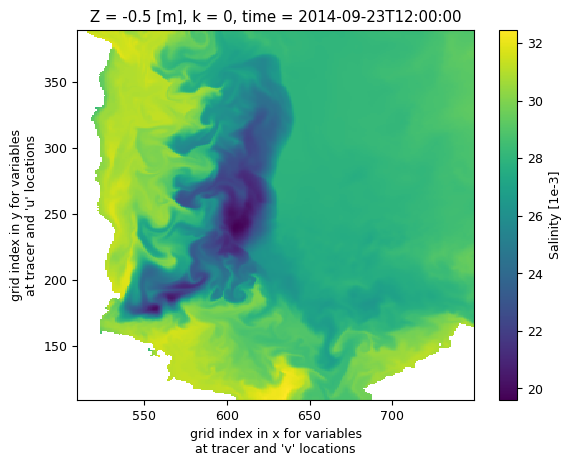

In [29]:
salt_beaufort.isel(time=0,k=0).plot();

In [30]:
salt_10m_over_2m = salt_beaufort.isel(k=slice(0,7)).mean(dim='k').where(fwc_yrs_masked>2)
salt_10m_under_2m = salt_beaufort.isel(k=slice(0,7)).mean(dim='k').where(fwc_yrs_masked<2)

sss_over_2m = salt_beaufort.isel(k=0).where(fwc_yrs_masked>2).load()
sss_under_2m = salt_beaufort.isel(k=0).where(fwc_yrs_masked<2).load()

In [35]:
# mean salinity in upper 10 m --------------------------
salt_10m_mean_over, salt_10m_std_over = normalize_and_avg_da(salt_10m_over_2m)
salt_10m_mean_under, salt_10m_std_under = normalize_and_avg_da(salt_10m_under_2m)

# mean surface salinity ---------------
sss_mean_over, sss_std_over = normalize_and_avg_da(sss_over_2m)
sss_mean_under, sss_std_under = normalize_and_avg_da(sss_under_2m)

In [36]:
def plot_var_mean(ax, var_mean_under, var_std_under, var_mean_over, var_std_over, upper_xy_limits=[80 ,100], title='SIC', ylabel=''):
    # Plot the variable mean + std shading for over and under FWC=2
    var_mean_over.plot(ax=ax, color='tab:blue', label='Plume')
    ax.fill_between(
        var_mean_over.days_since_min,
        var_mean_over - var_std_over,
        var_mean_over + var_std_over,
        color='tab:blue', alpha=0.2)

    var_mean_under.plot(ax=ax, color='k', label='Adjacent')
    ax.fill_between(
        var_mean_under.days_since_min,
        var_mean_under - var_std_under,
        var_mean_under + var_std_under,
        color='gray', alpha=0.2)

    ax.set_xlim(20, upper_xy_limits[0])
    ax.set_ylim(20, upper_xy_limits[1])
    ax.set_xlabel("")
    ax.set_title(title,size=15)
    ax.set_ylabel(ylabel)

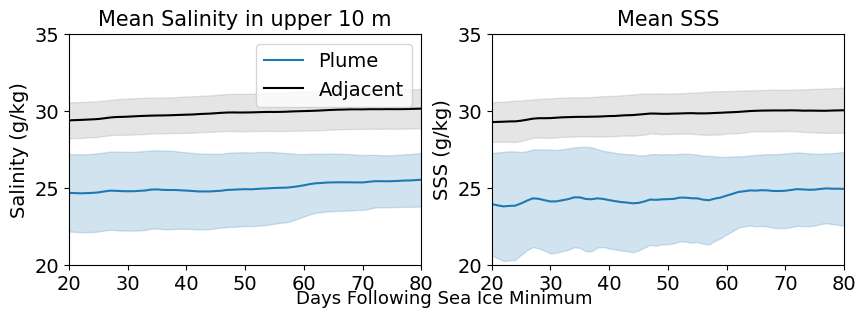

In [37]:
plt.rcParams['font.size'] = 14

fig, (ax1,ax2) = plt.subplots(1,2,figsize=[10,3])

plot_var_mean(ax1, salt_10m_mean_under, salt_10m_std_under, salt_10m_mean_over, salt_10m_std_over,
              upper_xy_limits=[80, 35], title='Mean Salinity in upper 10 m', ylabel='Salinity (g/kg)')
plot_var_mean(ax2, sss_mean_under, sss_std_under, sss_mean_over, sss_std_over,
              upper_xy_limits=[80, 35], title='Mean SSS', ylabel=r'SSS (g/kg)')

ax1.legend()

# Shared X-axis label
fig.text(0.5, -0.02, "Days Following Sea Ice Minimum", ha='center', size=13);

In [38]:
print(f'adjacent max: {sss_mean_under.max().values}')
print(f'adjacent min: {sss_mean_under.min().values}')
print(f'plume max: {sss_mean_over.max().values}')
print(f'plume min: {sss_mean_over.min().values}')

adjacent max: 30.30918308948794
adjacent min: 29.20205575872024
plume max: 24.972193765240345
plume min: 23.17388119283345


#### Now compute back of the envelope calculation for difference in freezing temperature based on mean salinity in upper 10 m

In [39]:
print(f'adjacent max: {salt_10m_mean_under.max().values}')
print(f'adjacent min: {salt_10m_mean_under.min().values}')
print(f'plume max: {salt_10m_mean_over.max().values}')
print(f'plume min: {salt_10m_mean_over.min().values}')

adjacent max: 30.430437524144534
adjacent min: 29.349223206432182
plume max: 25.595744297612637
plume min: 24.45117499310129


In [40]:
# Mean salinities (psu)
S_plume = 24.5   # plume waters
S_adj = 29.3     # adjacent waters

# Surface pressure (dbar)
p = 0

SA_plume = gsw.SA_from_SP(S_plume, p, lon=-140, lat=75)  # lon/lat arbitrary at surface
SA_adj = gsw.SA_from_SP(S_adj, p, lon=-140, lat=75)

# Freezing temperature at given salinity and pressure
Tf_plume = gsw.t_freezing(SA_plume, p, saturation_fraction=1.0)
Tf_adj = gsw.t_freezing(SA_adj, p, saturation_fraction=1.0)

print(f"Freezing temperature (plume, 24.6 psu): {Tf_plume:.3f} °C")
print(f"Freezing temperature (adjacent, 29.4 psu): {Tf_adj:.3f} °C")
print(f"Difference in freezing temperature: {Tf_adj - Tf_plume:.3f} °C")

Freezing temperature (plume, 24.6 psu): -1.330 °C
Freezing temperature (adjacent, 29.4 psu): -1.598 °C
Difference in freezing temperature: -0.268 °C


In [41]:
# Parameters
delta_Tf = 0.27      # °C, freezing temperature difference
Q = 100              # W/m², heat loss
H = 10               # m, mixed layer depth
cp = 3990            # J/kg/K, seawater heat capacity
rho = 1027           # kg/m³, seawater density
seconds_per_day = 86400

# Cooling rate (°C/day)
cooling_rate = Q * seconds_per_day / (cp * rho * H)

# Freeze delay (days)
freeze_delay = delta_Tf / cooling_rate
print(f"Expected freeze delay: {freeze_delay:.2f} days")

Expected freeze delay: 1.28 days
